### purpose

recreate the environmental figures from Lotterhos 2023

### notes

code almost identical to notebook 02.10.04 from https://github.com/brandonlind/mvp-offsets - I added a star to a MTN population

In [1]:
from pythonimports import *
from myfigs import save_pdf

import runtime_API as rt
import MVP_summary_functions as mvp
import MVP_06_validate_RONA as mvp06

import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D

fig_dir = makedir(f'{rt.resdir}/figures/05_supplemental/08_lotterhos_env_figs')

t0 = dt.now()

rt.latest_commit()
session_info.show()

#########################################################
Today:	August 12, 2024 - 16:00:43 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 6a767410e7b569adbf9df526de108f22ef50aad8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Mar 6 13:42:13 2024 -0700

Current commit of MVP_offsets:
commit 5ce82f4d655645237a0f4026fa32e220226dc373  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu May 16 13:02:58 2024 -0400

Current commit of MVP_runtime:
commit df87dd2c708ac0fdeebcfaaca239473ca2c487af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 19 16:17:46 2024 -0400
#########################################################



# map seed to landscape 

In [2]:
params = mvp.read_params_file()

seed_groups = params.groupby('landscape')['seed'].apply(list).to_dict()

for landscape, lseeds in seed_groups.items():
    print(landscape, lseeds[:5])

100%|███████████████| 2250/2250 [00:02<00:00, 861.04it/s]

Est-Clines [1231094, 1231095, 1231096, 1231097, 1231098]
SS-Clines [1231099, 1231100, 1231101, 1231102, 1231103]
SS-Mtn [1231104, 1231105, 1231106, 1231107, 1231108]


# functions for figures

In [19]:
# functions for plotting the conceptual landscape map
# modified from 06_run_time_project/05_supplement/03_all_compare_workflows.ipynb
def add_env2_legend(fig_object, fontsize=11, loc='center left', bbox_to_anchor=None, ncol=1, title=None,
                    size_mult=2):
    """Add pretty legend to figure, `fig_object`.
    
    Parameters
    ----------
    fig_object : [matplotlib.figure.Figure or matplotlib.axes._subplots.AxesSubplot]
        which object of the figure to add the legend
    fontsize : int
        the fontsize of the legend title and elements
    loc : str
        location of legend with respect to bbox_to_anchor location
    bbox_to_anchor : tuple
        Box that is used to position the legend in conjunction with *loc*.
    ncol : int
        the number of columns in the legend
    title : str
        legend title
    size_mult : float
        size multiplier
    """
    legend_kws = dict(title=f'$\it{title}$', fancybox=True, shadow=False,
                      facecolor='whitesmoke', loc=loc, bbox_to_anchor=bbox_to_anchor,
                      prop=dict(family='serif', size=fontsize))
    
    # get the things that go into the legend
    handles = []
    for size in sizes:
        handles.append(
            Line2D([0], [0], marker='o', color='none', markerfacecolor='k',
                   markeredgecolor='k',
                   label=Env2[size],
                   markersize=size_mult*size if size != 0 else 1)
        )

    # create a legend
    leg1 = fig_object.legend(handles=handles, ncol=ncol, **legend_kws)
    fig_object.add_artist(leg1)
    plt.setp(leg1.get_title(), family='serif', fontsize=fontsize+1)
    leg1.get_title().set_multialignment('center')

    return leg1

def plot_pnas(fig, ax, landscape='SS-Mtn'):
    """Plot a PNAS-style map for each landscape."""
    seed = seed_groups[landscape][0]; print(f'{seed = }')
    subset, locations, envdata = mvp06.get_pop_data(mvp.slimdir, seed)
    
    for pop, (lon, lat) in locations.iterrows():
        e, t = envdata.loc[pop, ['sal_opt', 'temp_opt']]
        # add garden location - newly added to original script
        if pop == 1 and landscape=='SS-Mtn':
            ax.scatter(
                lon,
                lat,
                s=400,
                marker='*',
                color='none',
                edgecolor='k',
            )
        # add black dot
        ax.scatter(
            lon,
            lat,
            s=50 * (sizes[Env2.index(e)] if landscape=='SS-Mtn' else 
                    temp_sizes[temp.index(e)]),
            color='k'
        )
        # add colored dot on top
        ax.scatter(
            lon,
            lat,
            s=30,
            color=coolwarm[temp.index(t)]
        )

    
    ax.set_title(mvp.factor_names[landscape],
                 fontdict={'fontsize' : 16, 'family' : 'serif'})

    if landscape == 'Est-Clines':
        # add temp color bar
        norm = mpl.colors.Normalize(vmin=-1, vmax=1)
        cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='coolwarm'), 
                          aspect=3,
                          ax=ax,
                          fraction=0.08,
                          anchor=(0, 1)
                         )
        cb.set_label(label='Temperature', size=12)

        # add env legend
        add_env2_legend(fig, title='Env2', loc='center left',
                        bbox_to_anchor=(0.92, 0.30), size_mult=1.5)

    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )
    
    return fig

In [9]:
# get data needed for all landscapes
subset, locations, envdata = mvp06.get_pop_data(mvp.slimdir, '1231104')

# other info for figs
sizes = [0, 1, 2, 3, 4]
Env2 = sorted(uni(envdata['sal_opt']))  # values of Env2 for Mtn

temp_sizes = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
temp = envdata.temp_opt.sort_values().unique().tolist()

# create temp color map
coolwarm = sns.color_palette("coolwarm", n_colors=10)  # for pnas map colorbar

pop_coolwarm = []  # plotting populations as in pnas
for pop, temp_opt in envdata['temp_opt'].items():
    pop_coolwarm.append(
        coolwarm[temp.index(temp_opt)]
    )
    
coolwarm


Reading in info for subsampled individuals ...


[(0.3383765114431373, 0.45281860883137254, 0.8793170768784313),
 (0.4570464785254902, 0.5940055499294118, 0.963029229690196),
 (0.5814861481882353, 0.7134505955294117, 0.9983143529411764),
 (0.7087196897176471, 0.8057213889294117, 0.9811168090470588),
 (0.8180564934117647, 0.8555896775450981, 0.9146376165490196),
 (0.9094595977529412, 0.8393864797647058, 0.8003313524235294),
 (0.9616447383764706, 0.7580291825411765, 0.6617823791647058),
 (0.963806056435294, 0.6341884145294118, 0.5137208491529413),
 (0.9182816725843137, 0.48417347218039214, 0.37779392507058823),
 (0.8301865219490197, 0.30473276355294115, 0.25489142806666665)]

# create figure

seed = 1231099

Reading in info for subsampled individuals ...
seed = 1231104

Reading in info for subsampled individuals ...
seed = 1231094

Reading in info for subsampled individuals ...
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/08_lotterhos_env_figs/landscape_layout.pdf


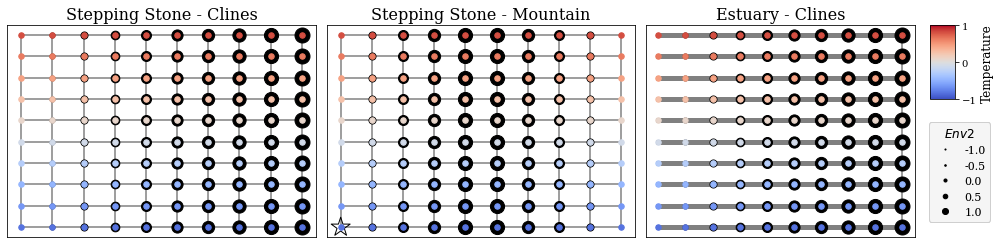

In [20]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 3.5))

for ax, landscape in zip(axes.flat, mvp.hue_order['landscape']):

    fig = plot_pnas(fig, ax, landscape)

# draw gray lines for SS-Mtn and SS-Clines
for ax in axes.flat[:2]:
    for i in range(1, 11, 1):
        x1 = (i, i)
        y1 = (1, 10)
        ax.plot(x1, y1, c='gray', zorder=0)
        
        x1 = (1, 10)
        y1 = (i, i)
        ax.plot(x1, y1, c='gray', zorder=0)
        
# draw gray lines for SS-Clines
ax = axes[-1]
ax.plot((10, 10), (1, 10), c='gray', zorder=0)
for i in range(1, 11, 1):
    ax.plot((1, 10), (i, i), c='gray', zorder=0, linewidth=5)

plt.tight_layout()

save_pdf(f'{fig_dir}/landscape_layout.pdf')

In [6]:
formatclock(dt.now() - t0)

'0-00:00:12'

In [7]:
formatclock(dt.now() - t0)

'0-00:00:12'